<a href="https://colab.research.google.com/github/murilo-henrique060/matematica-computacional/blob/main/Avalia%C3%A7%C3%A3o%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Busca de Raízes com o método da bisseção

Encontrar raízes de funções reais é uma técnica muito utilizada no meio da programação. Essa técnica é separada em 2 partes:
- Isolamento das raízes: Determinar intervalos que contenham uma raiz;
- Refinamento: Utilização de um algoritmo, como a bisseção, para determinar um valor aproximado para a raiz de cada intervalo encontrado.

Vamos utilizar de exemplo a função:
$$
f(x) = x^3 - 9x + 3
$$

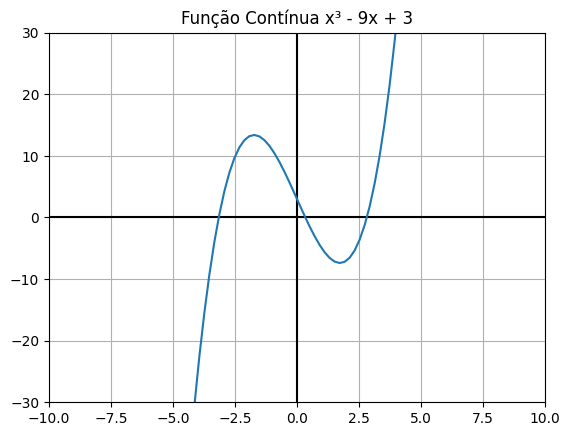

In [4]:
def plot(title=""):
  plt.title(title)
  plt.grid(True)
  plt.axhline(0, color='black')
  plt.axvline(0, color='black')
  plt.axis([-10, 10, -30, 30])

def plot_function(function):
  x_interval = np.linspace(-10, 10, 100)
  plt.plot(x_interval, function(x_interval))

f = lambda x: x**3 - 9 * x + 3

plot("Função Contínua x³ - 9x + 3")
plot_function(f)
plt.show()

## Isolamento de raízes

Para realizar o isolamento de raízes, podemos utilizar o Teorema do Valor Intermediário, que diz que, para uma função contínua $f(x)$ em um intervalo fechado $[a, b]$, se temos um valor $k$ entre $f(a)$ e $f(b)$, então temos, pelo menos, um ponto $c$ tal que $f(c)$ = k.

Baseado no teorema, podemos buscar intervalos $[a, b]$, tal que $f(a) > 0$ e $f(b) < 0$, ou que $f(a) < 0$ e $f(b) > 0$, ou seja, $f(a)$ e $f(b)$ devem ter sinais opostos.

Para simplificar a definição, podemos buscar pontos $a$ e $b$ tal que $f(a) \cdot f(b) < 0$.

### Método Iterativo

Para isolar as raízes, podemos definir um intervalo de busca e um passo, assim podemos separar o intervalo em seções para realizar a busca dos intervalos

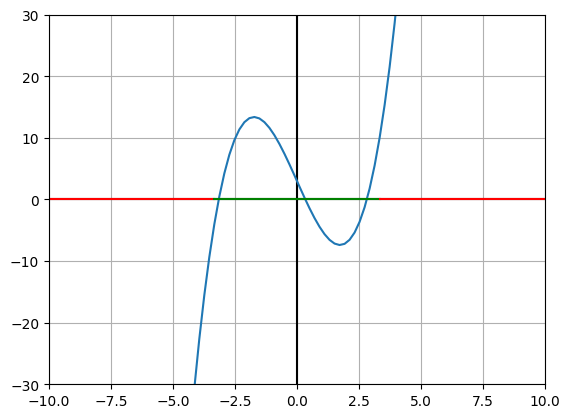

In [27]:
def root_isolation_basic(f, start=-10, end=10, sections=4, all=False, verbose=False):
  points = np.linspace(start, end, sections)

  for x, x1 in zip(points, points[1:]):
    hasRoots = f(x) * f(x1) < 0

    if verbose:
      print(f"x: {x:<6} f(x): {'-' if f(x) < 0 else '+'}")

    if (all or hasRoots):
      yield float(x), float(x1), hasRoots

  if verbose:
    print(f"x: {x1:<6} f(x): {'-' if f(x1) < 0 else '+'}")


plot()
plot_function(f)

intervals = root_isolation_basic(f, all=True)
for start, end, hasRoots in intervals:
  plt.plot((start, end), (0, 0), color="green" if hasRoots else "Red")

plt.show()

### Checagem de raízes

Para verificar se o intervalo contém apenas uma única raiz, podemos checar o sinal da derivada ao longo do intervalo, caso seja constante, confirmamos que há apenas uma derivada neste intervalo.

Para o exemplo apresentado teremos a derivada como:
$$
f'(x) = 3x^2 - 9
$$


In [30]:
def check_unique_root(d, start, end, samples=10):
  points = np.linspace(start, end, samples)

  for x, x1 in zip(points, points[1:]):
    if (d(x) * d(x1) < 0):
      return False

  return True

d = lambda x: 3 * x**2 - 9
intervals = list(root_isolation_basic(f))
print()

print("Intervalos: " + " ".join(f"[{x}, {x1}]" for x, x1, _ in intervals))

print()
for x, x1, _ in intervals:
  print(f"[{x}, {x1}] -> {'Tem raiz única' if check_unique_root(d, x, x1) else 'Contém mais de uma raiz'}")


Intervalos: [-3.333333333333333, 3.333333333333334]

[-3.333333333333333, 3.333333333333334] -> Contém mais de uma raiz


Então, no caso do intervalo conter mais de uma raiz, podemos realizar uma busca mais refinada para encontrar raízes únicas.

In [31]:
def root_isolation(f, d, start=-10, end=10, samples=4):
  intervals = []

  possible_intervals = root_isolation_basic(f, start, end, samples)
  for x, x1, _ in possible_intervals:
    if check_unique_root(d, x, x1):
      intervals.append((x, x1))
    else:
      intervals.extend(root_isolation(f, d, x, x1))

  return intervals

print(root_isolation(f, d))

[(-3.333333333333333, -2.592592592592592), (-1.1111111111111107, 1.1111111111111116), (2.5925925925925934, 3.333333333333334)]


In [6]:
def getRootIntervals(function, derivative, start=-100, end=100, step=2):
  """
  Get the intervals that have a root inside
  """
  intervals = []

  # Creating points in the interval
  x_values = np.arange(start, end, step)

  # Iterating all 2 adjacent points inside the interval
  for x, next in zip(x_values, x_values[1:]):
    f_x = function(x)
    f_next = function(next)

    deriv_x = derivative(x)
    deriv_next = derivative(next)

    # If the result of the function of the 2 points have oposite signals, means that inside the interval resides a root
    if f_x * f_next < 0:
      intervals.append((x, next))

    # If the result of the function of 2 points have same signal, but the derivatives have oposite signals,
    # means that inside the interval resides an even ammount of roots, therefore a more detailed search is needed.
    elif deriv_x * deriv_next < 0:
      intervals.extend(getRootIntervals(function, derivative, x, next))

  return intervals

In [7]:
def bissect(function, a, b, e=10**-3):
  f_a = function(a)

  x = None
  while b - a > e:
    x = (a + b) / 2
    f_x = function(x)

    if f_a * f_x >= 0:
      a = x
      f_a = f_x
    else:
      b = x

  return x

In [8]:
function = lambda x: x**3 - 5 * x**2 + 3 # x³ - 5x² + 3
derivative = lambda x: 3 * x**2 + 10 * x # 3x² + 10x

intervals = getRootIntervals(function, derivative)
for start, end in intervals:
  print(bissect(function, start, end))

-0.7236328125
0.8505859375
4.8740234375


In [9]:
def binary_to_fractions(bits, fractions=0):
  return sum(int(bit) * 2**(power) for power, bit in enumerate(reversed(bits), start=-fractions))

In [10]:
def integer_to_binary(value, places=8):
  result = ""

  while (value > 0 and len(result) < places):
    value, bit = divmod(value, 2)
    result = str(bit) + result

  return f"{result:>0{places}}"

def fractional_to_binary(value, places=8):
  result = ""

  while (value > 0 and len(result) < places):
    value *= 2
    bit = int(value)
    value -= bit

    result += str(bit)

  return f"{result:<0{places}}"

def to_binary(value, signed=False, integral_places=8, fractional_places=8):
  signal = ""
  if signed:
    signal = "0" if value >= 0 else "1"

  integral, fractional = divmod(abs(value), 1)
  integral = int(integral)

  return signal + integer_to_binary(integral, integral_places) + fractional_to_binary(fractional, fractional_places)

def format_binary(bits, signed=False, integral_places=8, fractional_places=8):
  signal = ""
  if signed:
    signal = "+" if bits[0] == "0" else "-"
    bits = bits[1:]

  integer = bits[:integral_places]
  fractional = bits[-fractional_places:]

  return signal + f"{integer.lstrip('0'):>01}" +  "." + f"{fractional.rstrip('0'):<01}"

format_binary(to_binary(12.3))

'1100.010011'

In [11]:
def float32_to_binary(bits):
  bias = 127

  signal = parse_binary_string(bits[0])
  biased_expoent = parse_binary_string(bits[1:9])
  mantissa = parse_binary_string(bits[9:], fractional=23)

  value = (-1)**signal * (1 + mantissa) * 2**(biased_expoent - bias)

  return to_binary(value)

bin_val = float32_to_binary("00111110010100000000000000000000")
print(bin_val)
print(format_binary(bin_val))
dec_val = binary_to_fractions(bin_val, 8)
print(dec_val)

NameError: name 'parse_binary_string' is not defined